In [1]:
#Packages:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from camera_matrix import camera_matrix
import time
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
# Read a sequence of 2 stereoscopic images, synchronized (frame 107 to 131 for video 1, frame 45 to 69 for video 2)
#cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/vid1_dx.MP4")
cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/GX010031.MP4")
#cap1 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/vid1_sx.MP4")

def save_BW_img(cap):
    image= []
    while True:
  # Lire l'image suivante de la vidéo
        ret, frame = cap.read()

  # Vérifier si la fin de la vidéo a été atteinte
        if not ret:
            break

  # Convertir l'image en noir et blanc
        img_gray= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        image.append(img_gray)
    cv2.destroyAllWindows()
    cap.release() 
    return image

        
dx_images = save_BW_img(cap0)
#sx_images = save_BW_img(cap1)


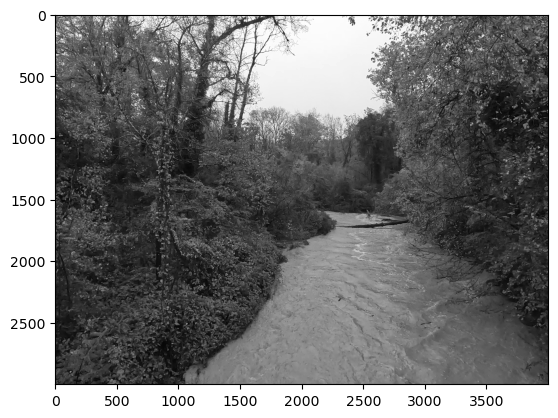

In [3]:
# Show two synchronized images
from PIL import Image
import matplotlib.pyplot as plt

image = dx_images[0]

plt.imshow(image, cmap='gray')

In [4]:
# Define the y-axis range
start_y = 2000
end_y = 2750

# define the x-axis range
start_x = 1850
end_x = 3000
# Define the size of the stripe
stripe_height = end_y - start_y
stripe_width = end_x - start_x

dx_stripes = []

# Loop through the images and select the stripe for each image
for img in dx_images:
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Select the stripe using array slicing
    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    dx_stripes.append(selected_stripe)

# Now, 'stripes' is a list containing the selected stripes from each image

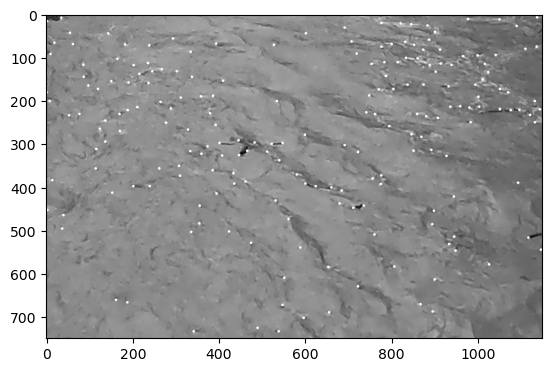

(<matplotlib.image.AxesImage at 0x14febacd0>, None)

In [5]:
nb_points = 200
def keypoint(nb_points, image):
    corners = cv2.goodFeaturesToTrack(image, nb_points,0.01,20)
    corners = np.intp(corners)
    return corners # les paires de coordonnées de chaque keypoints

corners = keypoint(nb_points, dx_stripes[0])
 
img_circles = dx_stripes[0].copy()

for i in corners:
 x,y = i.ravel()
 cv2.circle(img_circles,(x,y),3,255,-1)
 
plt.imshow(img_circles, cmap='gray'),plt.show()

In [6]:
def NCC_window(x,y, image): # normalized cross correlation window of 9x9 around our pixel of 
    # Do not forget that if x0-4 or x0+5 is out of the image, we will not take into account this tracking point. 
    NCC = image[y-4:y+5, x-4:x+5] # rows and columns are switched in the image ( image size is 750x1500)
    return NCC

In [26]:
def tracking(x0,y0,image, NCC):
    match = 0
    x1 = 0
    y1 = 0
    for x in range(x0-7, x0+7): 
        for y in range(y0-7, y0+7):
            img_comp = NCC_window(x,y,image)
            res = cv2.matchTemplate(img_comp,NCC, cv2.TM_CCORR_NORMED)
            if np.max(res) > match: 
                match = np.max(res)
                x1 = x
                y1 = y
    return(x1, y1)

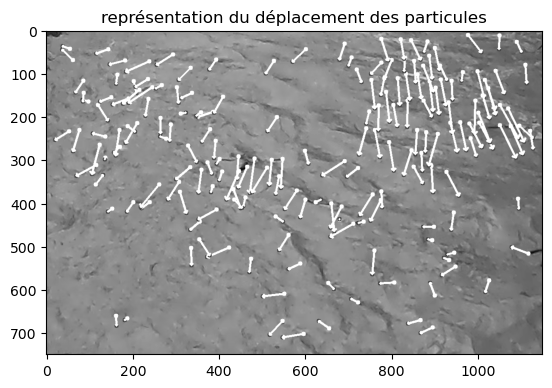

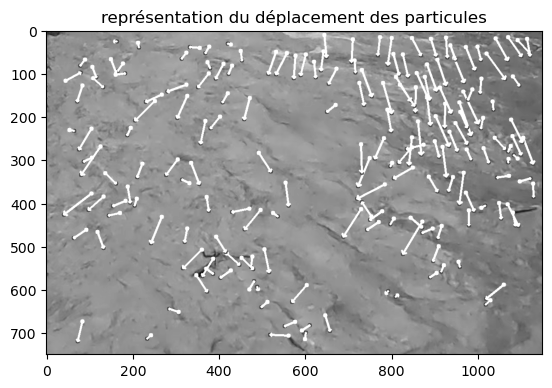

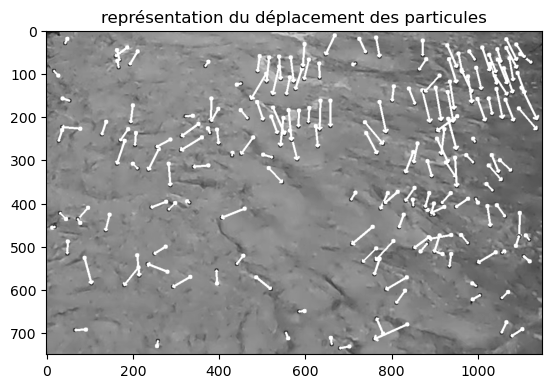

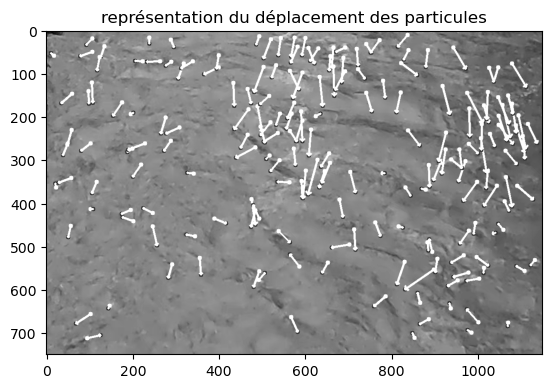

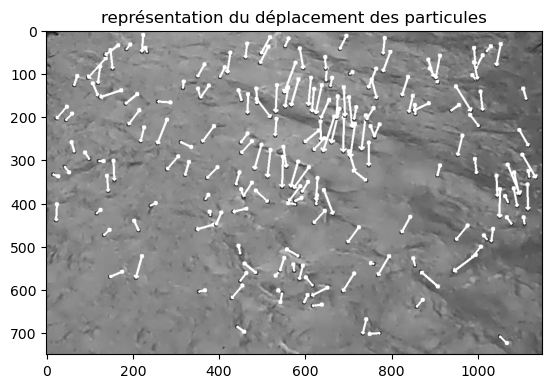

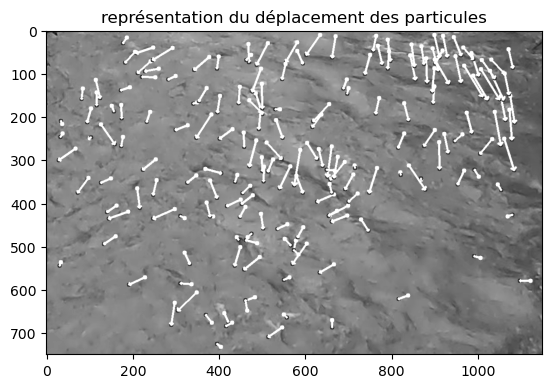

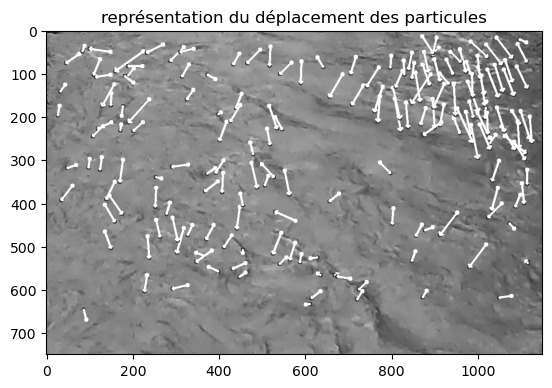

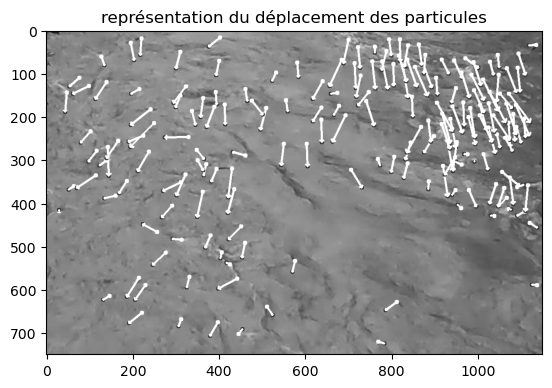

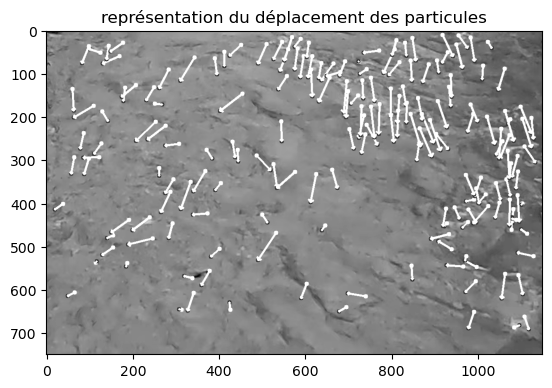

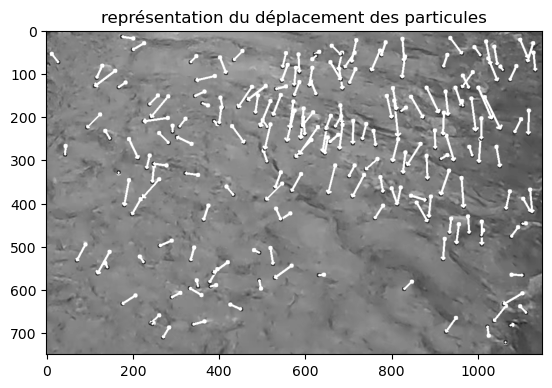

         x0     y0     x1     y1  direction     length
1778  375.0  174.0  362.0  169.0   1.203622  13.928388
1779  547.0  355.0  510.0  392.0  -0.785398  52.325902
1780  406.0  179.0  401.0  215.0  -0.138006  36.345564
1781  848.0  582.0  830.0  599.0  -0.813962  24.758837
1782  653.0  248.0  646.0  285.0  -0.186979  37.656341


In [27]:
stats = pd.DataFrame()

for img_nb in range(0, len(dx_stripes)):
    if img_nb % 30 == 0 and img_nb + 16 < len(dx_stripes): # la deuxieme condition est nécessaire pour pouvoir analyse les images jusqu'à la fin de la video
        corners = keypoint(nb_points, dx_stripes[img_nb])
        coord_track = corners[:,0,:2].ravel().reshape(nb_points,2)
        displacement = np.zeros((nb_points,15,2))
        point_i = 0
        point_delete = []
        for x,y in coord_track: # stripe-11 car sinon on est trop proche des bords et on ne peut pas faire d'image template
            for i in range(img_nb + 1, img_nb + 16):
                if x< 11 or x > stripe_width-11 or y < 11 or y > stripe_height-11: 
                    #stock les points à enlever
                    point_delete= np.append(point_delete, point_i)
                    break #skip au prochain point
                NCC = NCC_window(x,y, dx_stripes[i-1])
                displacement[point_i, i-1-img_nb ,:]= x,y
                x,y = tracking(x,y, dx_stripes[i], NCC)
            point_i += 1
        point_delete= point_delete.astype(int)
        displacement = np.delete(displacement,point_delete,0 )
        img_circles = dx_stripes[img_nb].copy()

        direction = []
        length = []
        for j in range(displacement.shape[0]):
            x0,y0 = displacement[j,0,:]
            x1,y1 = displacement[j,14,:]
            # recupere angle et taille des vecteurs

            if y1-y0 == 0: #trouver le moyen d'élimier les vecteurs ou on divise par 0
                angle = np.nan
                intensity = np.nan
            else: 
                angle = np.arctan((x1-x0)/(y1-y0))
                intensity = np.sqrt((x1-x0)*(x1-x0) + (y1-y0)*(y1-y0))
            
            direction = np.append(direction, angle)
            length= np.append(length, intensity)

            # représente les vecteurs sur les images
            cv2.circle(img_circles,(int(x0),int(y0)),5,255,-1)
            cv2.circle(img_circles,(int(x1),int(y1)),5,(70,255,212),-1)
            cv2.arrowedLine(img_circles, (int(x0),int(y0)), (int(x1),int(y1)), 255, 4)

        x0 = displacement[:, 0, 0]
        y0 = displacement[:, 0, 1]
        x1 = displacement[:, 14, 0]
        y1 = displacement[:, 14, 1]

        stats_temp = pd.DataFrame({
            'x0': x0,
            'y0': y0,
            'x1': x1,
            'y1': y1,
            'direction': direction,
            'length': length
        })
        stats = pd.concat([stats, stats_temp], ignore_index=True)
        plt.title('représentation du déplacement des particules')
        plt.imshow(img_circles, cmap = 'gray'),plt.show()

print(stats.tail())

Comment réduire la std? 
    - prendre en compte les jeux de luminosité
    - The distance thresholds canbe roughly approximated when the image scale and the range of expected river ﬂow velocity are known. In this study, the minimum and maximum distance parameters are set to 0.1and 10 pixels, respectively.
    - considers the directional ﬂow be-haviour of the feature with a steadiness parameter. Therefore,directions of sub-tracks (from frame to frame) are analysedfor each track. Tracks are excluded when the standard devi-ation is above a deﬁned threshold (30° in this study). Theidea is that river observations are performed during nearlyuniform ﬂow conditions. Thus, high frequencies of changesin ﬂow directions within a track indicate measurement errorsand should be ﬁltered. In addition to this steadiness param-eter, the range of all sub-track directions is also consideredas a measure of the ﬂow behaviour. If the range is above adeﬁned threshold, the track will be excluded (here 120°).

In [18]:
display(stats[['direction', 'length']].describe()) #cv2.TM_CCOEFF_NORMED

,direction,length
count,1744.000000,1744.000000
mean,-0.145688,42.663615
std,0.599436,17.980260
min,-1.548578,1.414214
25%,-0.571337,29.274562
50%,-0.129307,42.976732
75%,0.249550,55.946403
max,1.530818,89.944427


In [25]:
display(stats[['direction', 'length']].describe()) #cv2.TM_SQDIFF_NORMED

,direction,length
count,1771.000000,1771.000000
mean,-0.133026,47.982089
std,0.545380,17.479117
min,-1.547545,1.414214
25%,-0.490223,36.138622
50%,-0.120624,48.548944
75%,0.235134,60.212125
max,1.549966,94.921020


In [28]:
display(stats[['direction', 'length']].describe()) #cv2.TM_CCORR_NORMED

,direction,length
count,1773.000000,1773.000000
mean,-0.123533,40.004107
std,0.637340,17.630990
min,-1.552617,1.000000
25%,-0.572966,27.202941
50%,-0.103082,39.115214
75%,0.296546,52.239832
max,1.538549,88.192970


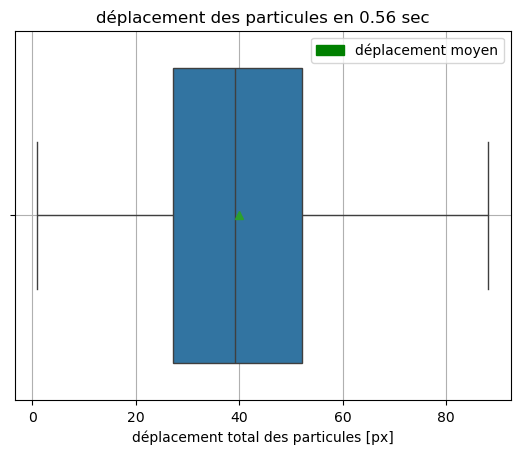

In [30]:
#boxplot= stats.boxplot(column = ['vertical_anlge'])
sns.boxplot(x="length", showmeans=True, data=stats)
#sns.despine(bottom=True)
mean_patch = mpatches.Patch(color='green', label='déplacement moyen')
plt.legend(handles=[mean_patch], loc='upper right')
plt.xlabel("déplacement total des particules [px]")
plt.title("déplacement des particules en 0.56 sec")
plt.grid(True)
plt.show()